Вам даны синтетические данные вида (x,f(x)), где x — вектор из 5 действительных чисел, а f(x) — действительное число.

Вам нужно решить задачу регрессии, обучившись на тренировочном датасете, и предсказать значение f(x) для всех x из тестового датасета.

Тренировочный датасет состоит из 80000 строк id,xid,f(xid) и заголовка. 

Ссылка на данные в формате csv: https://yadi.sk/d/_zDavEQwLTq-_tQ

Тестовый датасет состоит из 20000 строк id,xid и заголовка. 

Ссылка на данные в формате csv: https://yadi.sk/d/FVrLHez5_8UHxw

Отправленный файл должен состоять из 20000 строк вида id,fpredict(xid) и заголовка id,y. 

Ссылка на пример: https://yadi.sk/d/6-_Wz9YjJr561Gw

Метрика качества MAE: ошибка вычисляется по формуле S=∑|fpredicted(xid)−freal(xid)|.



In [1]:
import pandas as pd
from google.colab import files
from tensorflow.keras import utils
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Загружаем данные

In [3]:
data_train = pd.read_csv('/content/drive/My Drive/ИИ_2021/train.csv')
data_train

,id,x1,x2,x3,x4,x5,y
0,0,1,9,8,2,6,332.773904
1,1,0,8,0,2,7,298.091343
2,2,9,1,1,4,2,761.100225
3,3,7,9,2,8,6,686.106507
4,4,2,0,0,1,0,13.357220
...,...,...,...,...,...,...,...
79995,79995,6,4,1,1,4,304.940199
79996,79996,7,8,9,1,4,567.954361
79997,79997,6,5,0,8,1,301.367582
79998,79998,4,8,0,7,2,227.354170


In [4]:
print(max(data_train.x1))
print(max(data_train.x2))
print(max(data_train.x3))
print(max(data_train.x4))
print(max(data_train.x5))

9
9
9
9
9


максимальное значение 9, минимальное 0
to_categorical (1 на месте значения цифры)

0 - 1 0 0 0 0 0 0 0 0 0 

1 - 0 1 0 0 0 0 0 0 0 0 

2 - 0 0 1 0 0 0 0 0 0 0 

3 - 0 0 0 1 0 0 0 0 0 0 

4 - 0 0 0 0 1 0 0 0 0 0 

5 - 0 0 0 0 0 1 0 0 0 0

6 - 0 0 0 0 0 0 1 0 0 0 

7 - 0 0 0 0 0 0 0 1 0 0 

8 - 0 0 0 0 0 0 0 0 1 0

9 - 0 0 0 0 0 0 0 0 0 1 

y - standart_scale (нормализовать по стандартному распределению)

y - minmax_scale (нормализовать по максимальному значению)

In [5]:
data_test = pd.read_csv('/content/drive/My Drive/ИИ_2021/test.csv')
data_test

,id,x1,x2,x3,x4,x5
0,0,3,4,0,0,0
1,1,8,2,9,6,4
2,2,3,1,7,5,4
3,3,0,6,8,2,3
4,4,3,0,5,0,7
...,...,...,...,...,...,...
19995,19995,2,6,2,8,0
19996,19996,0,0,4,1,2
19997,19997,3,2,6,3,3
19998,19998,1,5,1,2,8


In [6]:
submission =  pd.read_csv('/content/drive/My Drive/ИИ_2021/submission.csv')
submission

,id,y
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
19995,19995,0
19996,19996,0
19997,19997,0
19998,19998,0


##Нормализация данных

In [7]:
x_train = data_train.values #вытаскиваем данные в массив numpy array
x_train = x_train[:,1:6] #возьмем только значения х1-х5

In [8]:
x_train = utils.to_categorical(x_train,10) #раскатегорируем данные
x_train.shape #размерность полученных данных - каждой цифре теперь 10 значений

(80000, 5, 10)

In [9]:
print(x_train[0]) #нулевой элемент

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [10]:
y_train = data_train.y #вытаскиваем игрики

In [11]:
# Приводим значения в диапазон от 0 до 1
min_y = y_train.min()
max_y = y_train.max()

In [12]:
y_train = (y_train - min_y) / (max_y - min_y) #отклонение от минимума к амплитуде
y_train

0        0.275670
1        0.246927
2        0.630634
3        0.568485
4        0.010962
           ...   
79995    0.252603
79996    0.470569
79997    0.249643
79998    0.188306
79999    0.257388
Name: y, Length: 80000, dtype: float64

In [13]:
print(x_train[0]) #в формате one_hot_encoding
print(data_train.values[0,1:6]) #цифры которые им соответствуют
print(y_train[0]) #соответствующие игрики

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
[1. 9. 8. 2. 6.]
0.2756697404194845


In [14]:
yTrain = data_train.values[:,6]

In [16]:
#Нормируем выход сети 
yScaler = StandardScaler() #Делаем нормальный нормировщик
yScaler.fit(yTrain.reshape(-1, 1)) #Обучаем на y_train
yTrainScaled = yScaler.transform(yTrain.reshape(-1, 1)) #Нормируем y_train

#Выводим размер и два примера для сравнения
#Не нормированных данных и нормированных
print(yTrainScaled.shape)
print(yTrain[0])
print(yTrainScaled[0])

(80000, 1)
332.7739038938621
[-0.06158646]


##Создадим соответствующие функции для обработки

In [17]:
def x_categorical(x_data):
  x = x_data.values
  x = x[:,1:6]
  x = utils.to_categorical(x,10)
  return x
def y_norm_min(y_data):
  y = y_data.values[:,6]
  min_y = y.min()
  max_y = y.max()
  y = (y - min_y) / (max_y - min_y) #отклонение от минимума к амплитуде
  y = y.reshape((y.shape[0],1))
  return y

In [18]:
x_train = x_categorical(data_train)
x_test = x_categorical(data_test)
y_train = y_norm_min(data_train)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(80000, 5, 10)
(20000, 5, 10)
(80000, 1)


In [19]:
xTrain = x_train.reshape(x_train.shape[0],50)

In [63]:
xTest = x_test.reshape(x_test.shape[0],50)

Формируем проверочную выборку

In [24]:
splitVal = 0.2 #Процент, который выделяем в проверочную выборку
valMask = np.random.sample(xTrain.shape[0]) < splitVal #Создаём маску True-False для создания проверочной выборки

#Нейронка - метрика MAE

Эпоха 0 модуль ошибки 110095.675
Эпоха 1 модуль ошибки 82550.877
Эпоха 2 модуль ошибки 49691.806
Эпоха 3 модуль ошибки 70468.44
Эпоха 4 модуль ошибки 41481.602
Эпоха 5 модуль ошибки 55071.577
Эпоха 6 модуль ошибки 35980.445
Эпоха 7 модуль ошибки 46391.805
Эпоха 8 модуль ошибки 36282.079
Эпоха 9 модуль ошибки 32880.808
Эпоха 10 модуль ошибки 25858.447
Эпоха 11 модуль ошибки 27312.762
Эпоха 12 модуль ошибки 29816.94
Эпоха 13 модуль ошибки 23064.45
Эпоха 14 модуль ошибки 34675.299
Эпоха 15 модуль ошибки 24591.291
Эпоха 16 модуль ошибки 29650.987
Эпоха 17 модуль ошибки 19699.905
Эпоха 18 модуль ошибки 31483.115
Эпоха 19 модуль ошибки 38084.136
Эпоха 20 модуль ошибки 19369.31
Эпоха 21 модуль ошибки 21634.785
Эпоха 22 модуль ошибки 21071.427
Эпоха 23 модуль ошибки 26270.019
Эпоха 24 модуль ошибки 38378.511
Эпоха 25 модуль ошибки 19780.181
Эпоха 26 модуль ошибки 21339.214
Эпоха 27 модуль ошибки 21187.481
Эпоха 28 модуль ошибки 22188.304
Эпоха 29 модуль ошибки 17363.131
Эпоха 30 модуль ошибки 

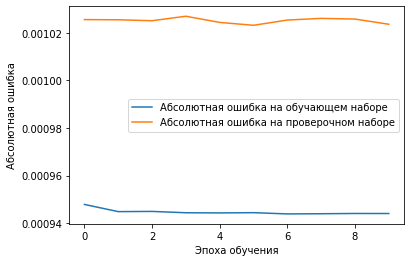

In [61]:
from keras.callbacks import LambdaCallback
from IPython.display import clear_output

def on_epoch_end(epoch, logs):
  pred = model5.predict(xTrain[valMask]) #Полуаем выход сети на проверочно выборке
  predUnscaled = yScaler.inverse_transform(pred).flatten() #Делаем обратное нормирование выхода к изначальным величинам цен квартир
  yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten() #Делаем такое же обратное нормирование yTrain к базовым ценам
  delta = predUnscaled - yTrainUnscaled #Считаем разность предсказания и правильных цен
  absDelta = abs(delta) #Берём модуль отклонения
  print("Эпоха", epoch, "модуль ошибки", round(sum(absDelta),3))

# Коллбэки
pltMae = LambdaCallback(on_epoch_end=on_epoch_end)

#Простая Dense сеть
input = Input((xTrain.shape[1],))

x = Dense(712, activation="relu")(input)
x = Dense(128, activation="relu")(x)
x = Dense(16, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model5 = Model(input, x)

model5.compile(optimizer=Adam(lr=1e-3), loss='mae')
history = model5.fit(xTrain[~valMask], 
                    yTrainScaled[~valMask], 
                    epochs=40, 
                    validation_data=(xTrain[valMask], 
                    yTrainScaled[valMask]), 
                    verbose=0,
                    callbacks=[pltMae])

print()
print('Меняем шаг обучения на 1e-4')
model5.compile(optimizer=Adam(lr=1e-4), loss='mae')
history = model5.fit(xTrain[~valMask], 
                    yTrainScaled[~valMask], 
                    epochs=40, 
                    validation_data=(xTrain[valMask], 
                    yTrainScaled[valMask]), 
                    verbose=0,
                    callbacks=[pltMae])

print()
print('Меняем шаг обучения на 1e-5')
model5.compile(optimizer=Adam(lr=1e-5), loss='mae')
history = model5.fit(xTrain[~valMask], 
                    yTrainScaled[~valMask], 
                    epochs=10, 
                    validation_data=(xTrain[valMask], 
                    yTrainScaled[valMask]), 
                    verbose=0,
                    callbacks=[pltMae])

print()
print('Меняем шаг обучения на 1e-6')
model5.compile(optimizer=Adam(lr=1e-6), loss='mae')
history = model5.fit(xTrain[~valMask], 
                    yTrainScaled[~valMask], 
                    epochs=10, 
                    validation_data=(xTrain[valMask], 
                    yTrainScaled[valMask]), 
                    verbose=0,
                    callbacks=[pltMae])


#Проверяем результаты
pred = model5.predict(xTrain) #Полуаем выход сети на проверочно выборке
predUnscaled = yScaler.inverse_transform(pred).flatten() #Делаем обратное нормирование выхода к изначальным величинам цен квартир
yTrainUnscaled = yScaler.inverse_transform(yTrainScaled).flatten() #Делаем такое же обратное нормирование yTrain к базовым ценам
delta = predUnscaled - yTrainUnscaled #Считаем разность предсказания и правильных цен
absDelta = abs(delta) #Берём модуль отклонения
print("Модуль ошибки", sum(absDelta)) 

#ВЫводим графики ошибки
plt.plot(history.history['loss'], 
         label='Абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Абсолютная ошибка')
plt.legend()
plt.show()

In [62]:
#Проверяем результаты
pred = model5.predict(xTrain) #Полуаем выход сети на проверочно выборке
predUnscaled = yScaler.inverse_transform(pred).flatten() #Делаем обратное нормирование выхода к изначальным величинам 
yTrainUnscaled = yScaler.inverse_transform(yTrainScaled).flatten() #Делаем такое же обратное нормирование yTrain 
delta = predUnscaled - yTrainUnscaled #Считаем разность предсказания и правильных 
absDelta = abs(delta) #Берём модуль отклонения
print("Модуль ошибки", sum(absDelta)) 

Модуль ошибки 19819.086353721872


In [69]:
model5.save_weights('model5.h5')

In [65]:
predTest = model5.predict(xTest)
predUnscaledTest = yScaler.inverse_transform(predTest).flatten() #Делаем обратное нормирование выхода к изначальным величинам 

In [66]:
submission

,id,y
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
19995,19995,0
19996,19996,0
19997,19997,0
19998,19998,0


In [67]:
predUnscaledTest

array([ 43.49099, 605.5679 ,  90.50579, ...,  88.43673, 199.53426,
       500.5999 ], dtype=float32)

In [68]:
submission.y = predUnscaledTest
submission

,id,y
0,0,43.490990
1,1,605.567871
2,2,90.505791
3,3,142.504944
4,4,42.509575
...,...,...
19995,19995,90.597832
19996,19996,17.527216
19997,19997,88.436729
19998,19998,199.534256


In [70]:
submission.to_csv('submission.csv',index=0)

In [71]:
s = pd.read_csv('submission.csv')
s

,id,y
0,0,43.490990
1,1,605.567900
2,2,90.505790
3,3,142.504940
4,4,42.509575
...,...,...
19995,19995,90.597830
19996,19996,17.527216
19997,19997,88.436730
19998,19998,199.534260
